# Example for system in Meyers, Craig and Odde 2006

Geometry is divided into 2 domains; one volume and one surface:
- PM
- Cytosol

This model has a single species, A, which is phosphorylated at the cell membrane. The unphosphorylated form of A ($A_{dephos}$) can be inferred from mass conservation; everywhere $c_{A_{phos}} + c_{A_{dephos}} = c_{Tot}$, which is a constant in both time and space if the phosphorylated vs. unphosphorylated forms have the same diffusion coefficient.

There are two reactions - one in the PM and other in the cytosol. At the membrane, $A_{dephos}$ is phosphorylated by a first-order reaction with rate $k_{kin}$, and in the cytosolic volume, $A_{phos}$ is dephosphorylated by a first order reaction with rate $k_p$.

Currently, this code includes a dummy variable, kinMem, which represents relative kinase activity at the membrane, currently set as constant at 1 (dimensionless). Without this additional species, the code currently does not solve the system (it seems that there needs to be variables in at least two compartments to solve the monolithic system).


In [ ]:
import os

import dolfin as d
import sympy as sym
import numpy as np

from stubs import unit, config, common, mesh, model
from stubs.model_assembly import Compartment, Parameter, Reaction, Species, sbmodel_from_locals
from matplotlib import pyplot as plt

First, we define the various units for the inputs

In [ ]:
# Aliases - base units
uM = unit.uM
um = unit.um
molecule = unit.molecule
sec = unit.sec
dimensionless = unit.dimensionless
# Aliases - units used in model
D_unit = um**2 / sec
flux_unit = molecule / (um**2 * sec)
vol_unit = uM
surf_unit = molecule / um**2

Next we generate the model.

In [ ]:
def make_model(curRadius):
    # =============================================================================================
    # Species
    # =============================================================================================
    # name, initial concentration, concentration units, diffusion, diffusion units, compartment
    Aphos = Species("Aphos", 0.1, vol_unit, 10.0, D_unit, "Cyto")
    kinMem = Species("kinMem", 1.0, dimensionless, 0.0, D_unit, "PM") # dummy variable; without this, the current version of SMART throws an error

    # =============================================================================================
    # Compartments
    # =============================================================================================
    # name, topological dimensionality, length scale units, marker value
    Cyto = Compartment("Cyto", 3, um, 1)
    PM = Compartment("PM", 2, um, 10)

    # =============================================================================================
    # Parameters and Reactions
    # =============================================================================================
    Atot = Parameter("Atot", 1.0, vol_unit)
    # Phosphorylation of Adephos at the PM
    kkin = Parameter("kkin", 50.0, 1/sec) 
    VolSA = Parameter("VolSA", curRadius/3, um) # vol to surface area ratio of the cell
    r1 = Reaction("r1", [], ["Aphos"], param_map={"kon": "kkin", "Atot": "Atot", "VolSA": "VolSA"},
        eqn_f_str="kinMem*kon*VolSA*(Atot - Aphos)", species_map={"Aphos": "Aphos","kinMem": "kinMem"}, explicit_restriction_to_domain="PM")
    # Dephosphorylation of Aphos in the cytosol
    kp = Parameter("kp", 10.0, 1/sec)
    r2 = Reaction("r2", ["Aphos"], [], param_map={"kon": "kp"},
         eqn_f_str="kon*Aphos", species_map={"Aphos": "Aphos"})

    # =============================================================================================
    # Gather all parameters, species, compartments and reactions
    # =============================================================================================
    return sbmodel_from_locals(locals().values())

We load the model generated above, and load in the mesh we will use in this example, iterating over 10 different values of cell radius, log-spaced between 1 and 10.

In [ ]:
radiusVec = np.logspace(0,1,num=10) # currently testing 10 radius values
ss_vec = np.zeros((10, 1))
for i in range(10):
    curRadius = radiusVec[i]
    pc, sc, cc, rc = make_model(curRadius)

    # =============================================================================================
    # Create/load in mesh
    # =============================================================================================
    # Base mesh
    domain, facet_markers, cell_markers = common.DemoSpheresMesh(curRadius, 0, hEdge = 0.2) # 0 in second argument corresponds to no inner sphere
    # Write mesh and meshfunctions to file
    os.makedirs(f"mesh_{i:03d}", exist_ok=True)
    common.write_mesh(domain, facet_markers, cell_markers, filename=f"mesh_{i:03d}/DemoSphere")

    # # Define solvers
    parent_mesh = mesh.ParentMesh(
        mesh_filename=f"mesh_{i:03d}/DemoSphere.h5",
        mesh_filetype="hdf5",
        name="parent_mesh",
    )
    configCur = config.Config()
    modelCur = model.Model(pc, sc, cc, rc, configCur, parent_mesh)
    configCur.solver.update(
        {
            "final_t": 1,
            "initial_dt": 0.01,
            "time_precision": 6,
            "use_snes": True,
            "print_assembly": False,
        }
    )

    modelCur.initialize(initialize_solver=False)
    modelCur.initialize_discrete_variational_problem_and_solver()
    # Write initial condition(s) to file
    results = dict()
    os.makedirs(f"resultsSphere_{i:03d}", exist_ok=True)
    for species_name, species in modelCur.sc.items:
        results[species_name] = d.XDMFFile(
            modelCur.mpi_comm_world, f"resultsSphere_{i:03d}/{species_name}.xdmf"
        )
        results[species_name].parameters["flush_output"] = True
        results[species_name].write(modelCur.sc[species_name].u["u"], modelCur.t)

    # Solve
    while True:
        # Solve the system
        modelCur.monolithic_solve()
        # Save results for post processing
        for species_name, species in modelCur.sc.items:
            results[species_name].write(modelCur.sc[species_name].u["u"], modelCur.t)
        # End if we've passed the final time
        if modelCur.t >= modelCur.final_t:
            break
    
    # compute steady state solution at the end of each run
    dx = d.Measure("dx",domain = modelCur.cc['Cyto'].dolfin_mesh)
    int_val = d.assemble(modelCur.sc['Aphos'].u['u']*dx)
    volume = d.assemble(1.0*dx)
    ss_val = int_val / volume
    ss_vec[i] = ss_val

np.savetxt(f"ss_vec.txt", ss_vec)

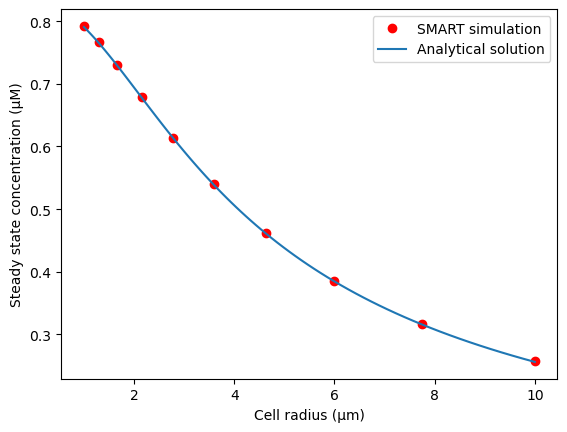

In [26]:
%matplotlib inline
plt.plot(radiusVec, ss_vec, 'ro')
radiusTest = np.logspace(0,1,100)
thieleMod = radiusTest / 1.0
k_kin = 50
k_p = 10
cT = 1
D = 10
C1 = k_kin*cT*radiusTest**2/((3*D*(np.sqrt(k_p/D)-(1/radiusTest)) + k_kin*radiusTest)*np.exp(thieleMod) +
        (3*D*(np.sqrt(k_p/D)+(1/radiusTest))-k_kin*radiusTest)*np.exp(-thieleMod))
cA = (6*C1/radiusTest)*(np.cosh(thieleMod)/thieleMod - np.sinh(thieleMod)/thieleMod**2)
plt.plot(radiusTest, cA)
plt.xlabel("Cell radius (μm)")
plt.ylabel("Steady state concentration (μM)")
plt.legend(("SMART simulation", "Analytical solution"))

RMSE with respect to analytical solution = 0.231%


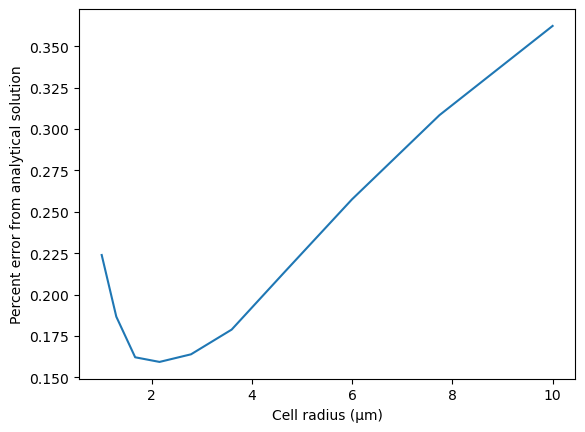

In [34]:
# quantify percent error
thieleMod = radiusVec / 1.0
k_kin = 50
k_p = 10
cT = 1
D = 10
C1 = k_kin*cT*radiusVec**2/((3*D*(np.sqrt(k_p/D)-(1/radiusVec)) + k_kin*radiusVec)*np.exp(thieleMod) +
        (3*D*(np.sqrt(k_p/D)+(1/radiusVec))-k_kin*radiusVec)*np.exp(-thieleMod))
cA = (6*C1/radiusVec)*(np.cosh(thieleMod)/thieleMod - np.sinh(thieleMod)/thieleMod**2)
percentError = 100*np.abs(ss_vec - cA) / cA
plt.plot(radiusVec,percentError)
plt.xlabel("Cell radius (μm)")
plt.ylabel("Percent error from analytical solution")
assert all(percentError < 1), f"Example 2 results deviate {max(percentError):.3f}% from the analytical solution"
rmse = np.sqrt(np.mean(percentError**2))
print(f"RMSE with respect to analytical solution = {rmse:.3f}%")

In [37]:
# check that solution is not too far from previous numerical solution (regression test)
ss_vec_ref = np.array([7.923821144851057596e-01, 7.669667883419870602e-01,
                       7.298498502029002744e-01, 6.788940529553533221e-01,
                       6.142454046569625348e-01, 5.396662231709322688e-01,
                       4.614726970070175405e-01, 3.858559025223168293e-01,
                       3.170657047898646219e-01, 2.570951001202800845e-01])
percentErrorRegression = 100*np.abs(ss_vec - ss_vec_ref) / ss_vec_ref
# not sure what the tolerated error should be for this regression test, currently set to 0.1%
assert all(percentErrorRegression < 0.1), f"Failed regression test: Example 2 results deviate {max(percentErrorRegression):.3f}% from the previous numerical solution"
rmse_regression = np.sqrt(np.mean(percentErrorRegression**2))
print(f"RMSE with respect to previous numerical solution = {rmse_regression:.3f}%")

RMSE with respect to previous numerical solution = 0.000%
